In [146]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import *

from collections import defaultdict, deque
import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
import torch



In [121]:
H = 32
W= 32
bs = 5

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [132]:
datasets.CIFAR10

torchvision.datasets.cifar.CIFAR10

In [141]:
class ImagenetRotation(datasets.CIFAR10):
    def __init__(self, path, transforms, degrees, train=True):
        super().__init__(path, train, download=True)
        self.transforms = transforms
        self.n_images_per_class = 50
        self.n_classes = 10
        self.degrees = degrees
        labelDict = {0:0,90:1,180:2,270:3}
        self.category = labelDict[self.degrees] 
        self.new2old_indices = self.create_idx_mapping()
        #print(self.new2old_indices)

    def create_idx_mapping(self):
        label2idx = defaultdict(lambda: deque(maxlen=self.n_images_per_class))
        for original_idx in range(super().__len__()):
            _, label = super().__getitem__(original_idx)
            label2idx[label].append(original_idx)

        old_idxs = set(itertools.chain(*label2idx.values()))
        new2old_indices = {}
        for new_idx, old_idx in enumerate(old_idxs):
            new2old_indices[new_idx] = old_idx

        return new2old_indices

    def __len__(self):
        return len(self.new2old_indices)

    def __getitem__(self, index):
        index = self.new2old_indices[index]
        im, _ = super().__getitem__(index)
        return rotate(self.transforms(im),self.degrees), self.category

In [142]:
class DatasetRotation(datasets.CIFAR10):
    def __init__(self, path, transforms, degrees, train=True):
        super().__init__(path, train, download=True)
        self.transforms = transforms
        self.n_images_per_class = 100
        self.n_classes = 1
        self.degrees = degrees
        labelDict = {0:0,90:1,180:2,270:3}
        self.category = labelDict[self.degrees] 
        self.new2old_indices = self.create_idx_mapping()

    def create_idx_mapping(self):
        label2idx = defaultdict(lambda: deque(maxlen=self.n_images_per_class))
        for original_idx in range(super().__len__()):
            _, label = super().__getitem__(original_idx)
            label2idx[label].append(original_idx)

        old_idxs = set(itertools.chain(*label2idx.values()))
        new2old_indices = {}
        for new_idx, old_idx in enumerate(old_idxs):
            new2old_indices[new_idx] = old_idx

        return new2old_indices

    def __len__(self):
        return len(self.new2old_indices)

    def __getitem__(self, index):
        index = self.new2old_indices[index]
        im, _ = super().__getitem__(index)
        return rotate(self.transforms(im),self.degrees), self.category

In [143]:
dt = DatasetRotation('data/',transform, d)
dt

Files already downloaded and verified


Dataset DatasetRotation
    Number of datapoints: 1000
    Root location: data/
    Split: Train
    Compose(
    Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [136]:
dts = []
for d in [0,90,180,270]:
    ds = DatasetRotation('data/',transform, d)
    dts.append(ds)
myDataset = torch.utils.data.ConcatDataset(dts)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [137]:
loader = DataLoader(myDataset, batch_size=10, shuffle=True)

In [138]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

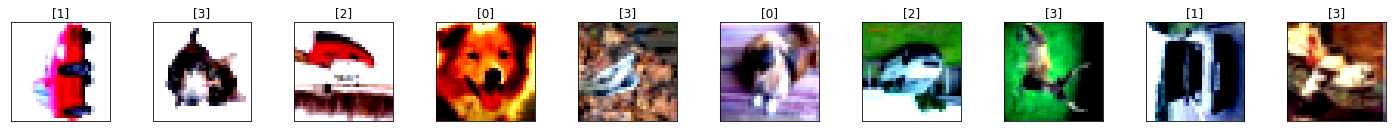

In [139]:
dataiter = iter(loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])